In [8]:
import pandas as pd
import re
import os

# Use current working directory (Jupyter-safe)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')

# Check current directory and file existence
print("Current working directory:", BASE_DIR)
print("Files in data directory:", os.listdir(DATA_DIR))

# Define full paths
RAW_DATA_PATH = os.path.join(DATA_DIR, 'raw_messages.csv')
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, 'processed_data.csv')

def clean_messages(df):
    # Convert to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract product mentions (update regex based on the CSV products)
    df['cleaned_products'] = df['message_text'].apply(
        lambda x: re.findall(r'(VersaFlex Speaker|EcoBreeze Air Purifier|ClearView Smart Camera|SwiftCharge Power Bank|OmniFit Smartwatch)', x)
    )

    # Remove empty messages
    df = df[df['message_text'].str.strip().str.len() > 0]

    return df

# Load, process, and save
raw_data = pd.read_csv(RAW_DATA_PATH)
clean_data = clean_messages(raw_data)
clean_data.to_csv(PROCESSED_DATA_PATH, index=False)

print("Processing complete. Cleaned data saved to:", PROCESSED_DATA_PATH)


Current working directory: e:\project\chatbot-data-analysis\notebook
Files in data directory: ['processed_data.csv', 'raw_messages.csv']
Processing complete. Cleaned data saved to: e:\project\chatbot-data-analysis\notebook\..\data\processed_data.csv


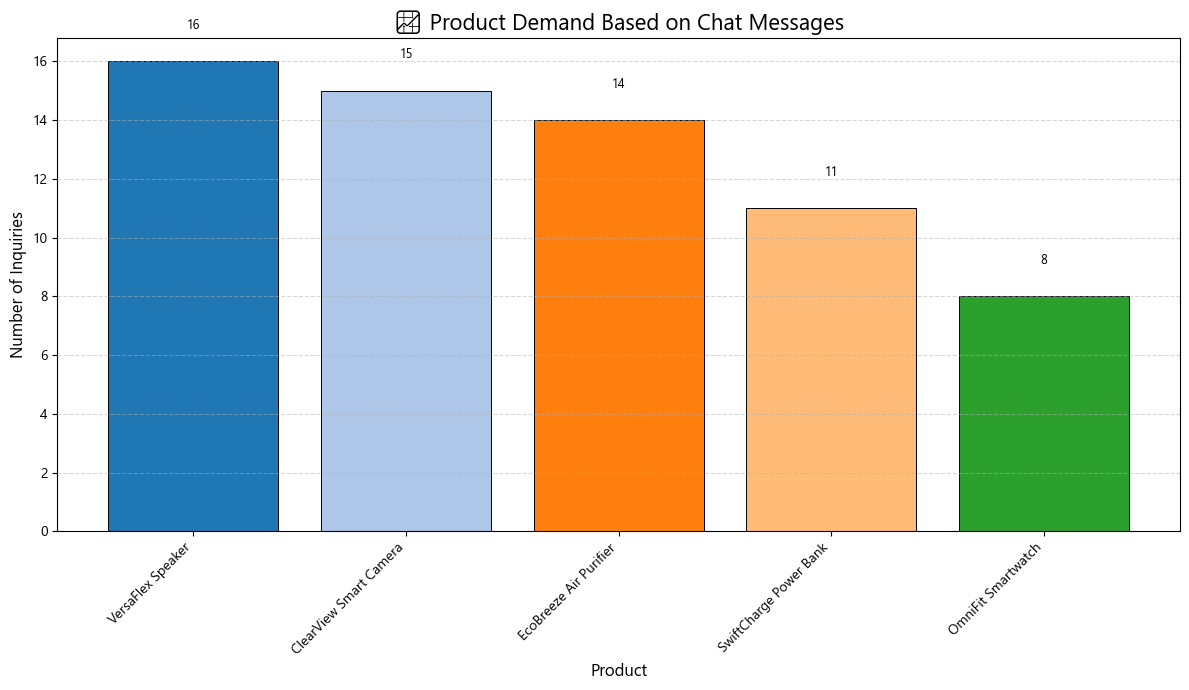

🔥 High Demand Products:
                  product  message_count
0       VersaFlex Speaker             16
1  ClearView Smart Camera             15
2  EcoBreeze Air Purifier             14

❄️ Low Demand Products:
                  product  message_count
4      OmniFit Smartwatch              8
3  SwiftCharge Power Bank             11
2  EcoBreeze Air Purifier             14


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Ensure proper font for Emojis and text
import os

# Setup directory paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')  
DATA_DIR = os.path.abspath(DATA_DIR)

# Load processed data
data = pd.read_csv(os.path.join(DATA_DIR, 'processed_data.csv'))

# Product demand analysis: Count occurrences of each product mentioned
product_demand = data['product_mentioned'].value_counts().reset_index()
product_demand.columns = ['product', 'message_count']

# Define custom colors for each product (up to 20 distinct colors)
colors = plt.cm.tab20.colors
bar_colors = colors[:len(product_demand)]  # Select the necessary number of colors

# Plot the bar chart
plt.figure(figsize=(12, 7))
bars = plt.bar(
    product_demand['product'],
    product_demand['message_count'],
    color=bar_colors,
    edgecolor='black',
    linewidth=0.7
)

# Annotate each bar with its value (count of messages)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', 
             ha='center', va='bottom', fontsize=9)

# Design improvements
plt.title('📈 Product Demand Based on Chat Messages', fontsize=16, fontweight='bold')
plt.xlabel('Product', fontsize=12)
plt.ylabel('Number of Inquiries', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot in the desired output directory
output_path = os.path.join(BASE_DIR, '..', 'reports', 'figures', 'demand_trends.png')
output_path = os.path.abspath(output_path)
plt.savefig(output_path)
plt.show()

# High & low demand product analysis
high_demand = product_demand.nlargest(3, 'message_count')
low_demand = product_demand.nsmallest(3, 'message_count')

print("🔥 High Demand Products:")
print(high_demand)
print("\n❄️ Low Demand Products:")
print(low_demand)


c:\Users\redwa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


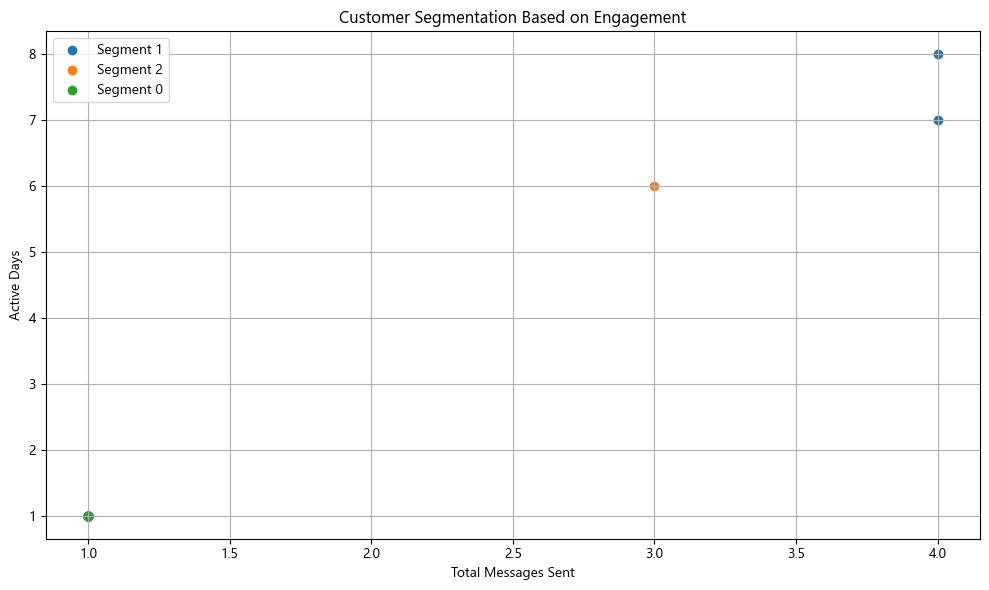

Segment Analysis Summary:
   segment  message_count  active_days  user_id
0        0            1.0          1.0       53
1        1            4.0          7.5        2
2        2            3.0          6.0        1


In [10]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Limit OpenMP threads to avoid multi-threading issues

# Setup directory
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')  
DATA_DIR = os.path.abspath(DATA_DIR) 

# Load the data
data = pd.read_csv(os.path.join(DATA_DIR, 'processed_data.csv'))

# Prepare customer engagement metrics
# Convert 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Aggregating customer engagement data by user_id
customer_data = data.groupby('user_id').agg(
    message_count=('timestamp', 'count'),
    active_days=('timestamp', lambda x: (x.max() - x.min()).days + 1 if x.nunique() > 1 else 1),
    avg_response_time=('response_time', 'mean')
).reset_index()

customer_data.columns = ['user_id', 'message_count', 'active_days', 'avg_response_time']

# Normalize data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['message_count', 'active_days']])

# K-Means clustering (3 segments)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['segment'] = kmeans.fit_predict(scaled_data)

# Visualize the segments
plt.figure(figsize=(10, 6))
for segment in customer_data['segment'].unique():
    subset = customer_data[customer_data['segment'] == segment]
    plt.scatter(subset['message_count'], subset['active_days'], label=f'Segment {segment}')

plt.title('Customer Segmentation Based on Engagement')
plt.xlabel('Total Messages Sent')
plt.ylabel('Active Days')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
output_path = os.path.join(BASE_DIR, '..', 'reports', 'figures', 'customer_segments.png')
output_path = os.path.abspath(output_path)
plt.savefig(output_path)
plt.show()

# Segment analysis: Summary statistics of each segment
segment_stats = customer_data.groupby('segment').agg({
    'message_count': 'mean',
    'active_days': 'mean',
    'user_id': 'count'  # Count of users per segment
}).reset_index()

print("Segment Analysis Summary:")
print(segment_stats)
